In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import os
from pygifsicle import optimize
import imageio
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)

from matplotlib.lines import Line2D

In [2]:
## Download the three shapefiles
geo_df= gpd.read_file("shapefiles/ne_10m_admin_1_states_provinces.shp")
geo_df2 = gpd.read_file("shapefiles/ne_10m_admin_0_disputed_areas.shp")
cities_df= gpd.read_file("shapefiles/ne_10m_populated_places.shp")

## Lower names of columns
geo_df2.columns = [x.lower() for x in geo_df2.columns]
cities_df.columns = [x.lower() for x in cities_df.columns]

## Add a column to seperate cities from regions
cities_df['city'] = True
geo_df2['city'] = ""
geo_df['city'] = ""

## Concat the columns together
geo_df = pd.concat([geo_df,geo_df2,cities_df])

geo_df =  geo_df[['iso_a2','name','geometry','name_en', 'adm1_code','iso_3166_2','city']]
geo_df[['name_en',"adm1_code","iso_3166_2"]] = geo_df[['name_en',"adm1_code","iso_3166_2"]].fillna("")
manual_df = pd.read_excel('datafile.xlsx',keep_default_na=False)
geo_df = geo_df.merge(manual_df, on=['iso_a2','name','name_en', 'adm1_code','iso_3166_2','city'],how='right')
date_cols = sorted(set(geo_df.columns) - {'iso_a2','name','name_en', 'adm1_code','iso_3166_2','geometry','city'})
geo_df.head()

,iso_a2,name,geometry,name_en,adm1_code,iso_3166_2,city,20200101,20200102,20200103,...,20200304,20200305,20200306,20200307,20200308,20200309,20200310,20200311,20200312,20200313
0,AR,Entre Ríos,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4...",Entre Ríos Province,ARG-1309,AR-E,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow
1,UY,Paysandú,"POLYGON ((-58.20012 -32.44720, -58.20011 -32.4...",Paysandú Department,URY-8,UY-PA,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow
2,PK,Sind,"MULTIPOLYGON (((68.18304 23.84216, 68.18301 23...",Sindh,PAK-1114,PK-SD,,orange,orange,orange,...,orange,orange,orange,orange,orange,orange,orange,orange,orange,orange
3,IN,Gujarat,"POLYGON ((68.18301 23.84209, 68.18304 23.84216...",Gujarat,IND-3264,IN-GJ,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,orange,orange
4,ID,Kalimantan Timur,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",East Kalimantan,IDN-1185,ID-KI,,yellow,yellow,yellow,...,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow,yellow


In [3]:
category1 = 'green'
category2 = 'yellow'
category3 = 'orange'
category4 = "red"
unknown = "grey"
city_marker_size = 0.3

interactive(children=(IntSlider(value=1, description='datenr', max=73, min=1), Output()), _dom_classes=('widge…

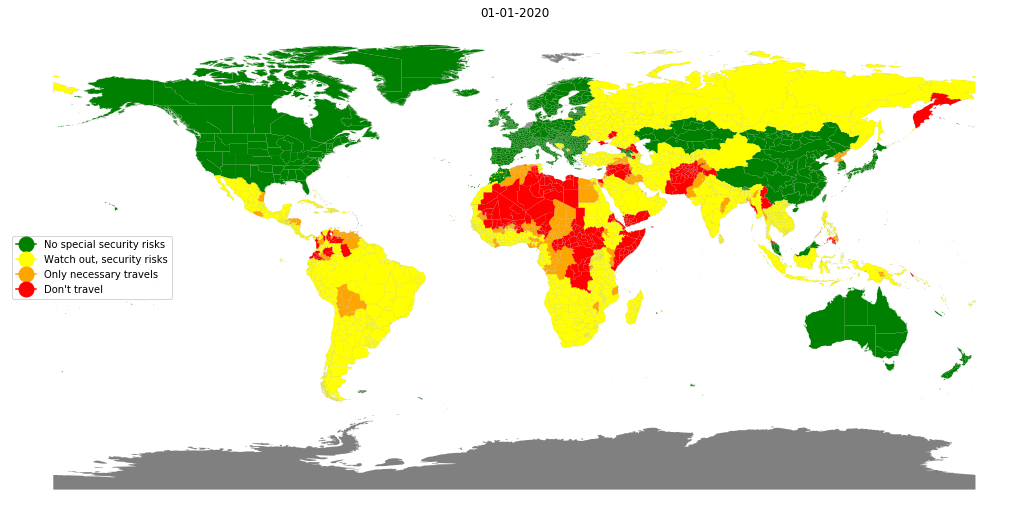

In [4]:
def create_world_map(datenr,show_plot):
    column_name = date_cols[datenr-1]
    fig, ax = plt.subplots(figsize=(30,9))
    
    category1_df = geo_df[(geo_df[column_name] == category1) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
    category1_df.plot(color='green',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category2_df = geo_df[(geo_df[column_name] == category2) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
    category2_df.plot(color='yellow',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category3_df = geo_df[(geo_df[column_name]==category3) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
    category3_df.plot(color='orange',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category4_df = geo_df[(geo_df[column_name]==category4) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
    category4_df.plot(color='red',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    unknown_df = geo_df[(geo_df[column_name]==unknown) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
    unknown_df.plot(color='grey',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category1_df99 = geo_df[(geo_df[column_name]==category1) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
    category1_df99.plot(color='green',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category2_df99 = geo_df[(geo_df[column_name]==category2) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
    category2_df99.plot(color='yellow',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category3_df99 = geo_df[(geo_df[column_name]==category3) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
    category3_df99.plot(color='orange',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    category4_df99 = geo_df[(geo_df[column_name]==category4) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
    category4_df99.plot(color='red',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

    unknown_df99 = geo_df[(geo_df[column_name]==unknown) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
    unknown_df99.plot(color='grey',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);
    
    
    cities1 = geo_df[(geo_df[column_name]==category1) & (geo_df['city']==True)]
    cities1.plot(color='green',ax=ax,legend=True,marker='o',markersize=city_marker_size);

    cities2 = geo_df[(geo_df[column_name]==category2)  & (geo_df['city']==True)]
    cities2.plot(color='yellow',ax=ax,legend=True,marker='o',markersize=city_marker_size);

    cities3 = geo_df[(geo_df[column_name]==category3) & (geo_df['city']==True)]
    cities3.plot(color='orange',ax=ax,legend=True,marker='o',markersize=city_marker_size);

    cities4= geo_df[(geo_df[column_name]==category4) &(geo_df['city']==True)]    
    cities4.plot(color='red',ax=ax,legend=True,marker='o',markersize=city_marker_size);



    legend_elements = [Line2D([0], [0], marker='o', color='green', label="No special security risks",markerfacecolor='g', markersize=15),
                      Line2D([0], [0], marker='o', color='yellow', label="Watch out, security risks",markerfacecolor='yellow', markersize=15),
                      Line2D([0], [0], marker='o', color='orange', label="Only necessary travels",markerfacecolor='orange', markersize=15),
                      Line2D([0], [0], marker='o', color='red', label="Don't travel",markerfacecolor='r', markersize=15)]
    ax.legend(handles=legend_elements, loc='center left')
    ax.set_facecolor('white')
    plt.axis('off');
    plt.title("%s-%s-%s" %(column_name[-2:],column_name[4:-2],column_name[:4]));
    
    plt.savefig('maps_for_gif/%s.jpg' %column_name, bbox_inches = 'tight',pad_inches = 0, dpi=100);
    if show_plot:
        plt.show()
    plt.close()
interact(create_world_map, datenr=widgets.IntSlider(min=1, max=len(date_cols), step=1, value=1),show_plot=fixed(True));

In [5]:
## Create a world map for every date
for i in tqdm(range(1,len(date_cols)+1)):
     create_world_map(i, False)

## Turn all images into one gif
os.remove('movie.gif')
filenames=sorted(os.listdir('maps_for_gif'))
with imageio.get_writer('movie.gif', mode='I',duration=0.2) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('maps_for_gif/'+filename)
        writer.append_data(image)
## Compress the gif
optimize("movie.gif","compressed.gif")

In [ ]:
# Save latest map in HQ
column_name = date_cols[-1]
fig, ax = plt.subplots(figsize=(30,9))

category1_df = geo_df[(geo_df[column_name] == category1) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
category1_df.plot(color='green',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category2_df = geo_df[(geo_df[column_name] == category2) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
category2_df.plot(color='yellow',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category3_df = geo_df[(geo_df[column_name]==category3) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
category3_df.plot(color='orange',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category4_df = geo_df[(geo_df[column_name]==category4) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
category4_df.plot(color='red',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

unknown_df = geo_df[(geo_df[column_name]==unknown) & (geo_df['iso_a2']!="-99") & (geo_df['city']=="")]
unknown_df.plot(color='grey',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category1_df99 = geo_df[(geo_df[column_name]==category1) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
category1_df99.plot(color='green',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category2_df99 = geo_df[(geo_df[column_name]==category2) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
category2_df99.plot(color='yellow',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category3_df99 = geo_df[(geo_df[column_name]==category3) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
category3_df99.plot(color='orange',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

category4_df99 = geo_df[(geo_df[column_name]==category4) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
category4_df99.plot(color='red',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);

unknown_df99 = geo_df[(geo_df[column_name]==unknown) & (geo_df['iso_a2']=="-99") & (geo_df['city']=="")]
unknown_df99.plot(color='grey',ax=ax,legend=True,edgecolor='grey',linewidth=0.05);


cities1 = geo_df[(geo_df[column_name]==category1) & (geo_df['city']==True)]
cities1.plot(color='green',ax=ax,legend=True,marker='o',markersize=city_marker_size);

cities2 = geo_df[(geo_df[column_name]==category2)  & (geo_df['city']==True)]
cities2.plot(color='yellow',ax=ax,legend=True,marker='o',markersize=city_marker_size);

cities3 = geo_df[(geo_df[column_name]==category3) & (geo_df['city']==True)]
cities3.plot(color='orange',ax=ax,legend=True,marker='o',markersize=city_marker_size);

cities4= geo_df[(geo_df[column_name]==category4) &(geo_df['city']==True)]    
cities4.plot(color='red',ax=ax,legend=True,marker='o',markersize=city_marker_size);



legend_elements = [Line2D([0], [0], marker='o', color='green', label="No special security risks",markerfacecolor='g', markersize=15),
                  Line2D([0], [0], marker='o', color='yellow', label="Watch out, security risks",markerfacecolor='yellow', markersize=15),
                  Line2D([0], [0], marker='o', color='orange', label="Only necessary travels",markerfacecolor='orange', markersize=15),
                  Line2D([0], [0], marker='o', color='red', label="Don't travel",markerfacecolor='r', markersize=15)]
ax.legend(handles=legend_elements, loc='center left')
ax.set_facecolor('white')
plt.axis('off');
plt.title("%s-%s-%s" %(column_name[-2:],column_name[4:-2],column_name[:4]));
plt.savefig('most_recent_map.jpg', bbox_inches = 'tight',pad_inches = 0, dpi=1080);